<br></br>
<h1 style = "font-weight:bold;"> Higgs-Suche mit Python </h1>

> von Kai Adamowicz und Philipp Nattland, basierend auf der CMS Open Data Analyse *"Analysis of Higgs boson decays to four leptons using data and simulation of events at the CMS detector from 2012 using ROOT's RDataFrame"* von Stefan Wunsch auf [https://opendata.cern.ch/record/12360](https://opendata.cern.ch/record/12360)

Das Standardmodel der Teilchenphysik ist ein wohlerprobtes Model um die Interaktionen von Teilchen vorrauszusagen. Es wurde jedoch nicht an einem Tag erschaffen sondern über viele Jahzehnte durch unzählige Experimente sorgfältig Stein um Stein aufgebaut. Viele Fragen und Rätsel um das Standardmodel blieben jedoch eine lange Zeit unbeantwortet. So zum Beispiel die Frage warum das Photon - das Austauschteilchen der elektromagnetischen Wechselwirkung - masselos ist, während das $W$- und $Z$-Boson - die Austauschteilchen der schwachen Wechselwirkung - massiv sind. 1964 stellte Peter Higgs (sowie mehrere weitere Wissenschaftler) eine Theorie vor, welche diese Inkonsistenz erklären kann ohne dem Rest des Standardmodels zu widersprechen. Diese Theorie implizierte jedoch die Existenz eines neuen, bisher unbekannten Teilchens - das **Higgs** Boson. Eine lange Zeit blieb es unentdeckt, das LEP Experiment (Vorgänger des LHC Experiments) endete mit dem Ergebnis, dass das Higgs Boson eine Masse von über $114 \ \text{GeV}$ haben muss - denn schwerere Teilchen konnte das LEP aus technischen Gründen nicht erzeugen. Das nachfolgende LHC Experiment ist in der Lage Teilchen mit deutlich höheren Massen zu erzeugen und sollte das Mysterium um das Higgs Boson endlich lösen.

Im Sommer 2012 verkündeten die **CMS** und **ATLAS** Kollaborationen die Entdeckung eines neuen Teilchens am CERN LHC. Die Eigenschaften des Teilchens stimmten mit der Theorie von Peter Higgs und seinen Kollegen überein. Das Higgs Boson wurde gefunden - bei einer Masse von ca. $125 \ \text{GeV}$ - nur knapp ausserhalb der maximalen Reichweite des LEP Experiments. Im folgenden Jupyter Notebook werden wir die Schritte der CMS Wissenschaftler nachvollziehen und das Higgs Boson im $\text{H}\to\text{ZZ}\to4\ell$ Kanal erneut "entdecken". Dafür verwenden wir die gleichen Daten, die 2012 zur Entdeckung geführt haben.
> **Good to know:** Zur Entdeckung des Higgs Bosons trugen auch andere Zerfallskanäle, wie z.B. $\text{H}\to\gamma\gamma$ bei (Das $\gamma$ bezeichnet hier das Photon).


**Überblick**
<ul>
 <li><a href="#datsensatz">I. Der Datensatz</a></li>
 <li><a href="#objekte">II. Definition der Objekte</a></li>
 <li><a href="#selektion">III. Sellektion der Events</a></li>
 <li><a href="#simulation">IV. Vergleich mit Simulation</a></li>
 <li><a href="#extrkation">V. Extraktion des Signals</a></li>
</ul>

<a name="datensatz"></a>

## Der Datensatz
<hr>

Wie bereits erwähnt werden wir die originalen Datensätze verwenden, die 2012 zur Entdeckung des Higgs Bosons beigetragen haben. Diese wurden von der CMS Kollaboration öffentlich gemacht und können auf der CERN Open Data Plattform gefunden werden. Wie ihr in der Einführung gelernt habt, nimmt das **CMS** Experiment unvorstellbar große Datenmengen auf, daher ist unpraktisch **alle** aufgenommen Daten hier zu analysieren. Stattdessen wurde eine Vorauswahl an Daten getätigt, um die Dateigröße zu reduzieren. Da wir an dem $\text{H}\to\text{ZZ}\to4\ell$ Prozess interessiert sind, ist das Hauptkriterium, auf Basis dessen wir diese Vorauswahl getätigt haben, dass in jedem Event mindestens 4 Leptonen (also Elektronen oder Myonen) enthalten sein müssen. Auf diese Weise konnten wir die Datenmenge um ein Vielfaches reduzieren und gleichzeitig einen großen Teil der $\text{H}\to\text{ZZ}\to4\ell$ Events beibehalten.

Zunächst importieren wir verschiedene Module, welche wir für die Analyse benötigen. Diese enthalten nützliche *Funktionen* (siehe Python-Übung), welchen wir lediglich ein paar Parameter übergeben müssen, um eine bestimmte Aufgabe zu lösen. Um die Funktionen aus den Bibliotheken zu laden, führe einfach die nächsten Zeilen aus.

In [1]:
import awkward as ak   # Wichtiges Modul um große Arrays zu bearbeiten
from helpers import *  # Alle Funktionen aus unserem selbtgeschriebenen "helpers" Modul

Mit den geladenen Funktionen können wir nun die Daten einlesen. Die entsprechenden Dateien sind im Ordner `data_files` gespeichert. Mit dem Folgenden Befehl werden alle Dateien eingelesen und dem *dict* `data` hinzugefügt.  

In [2]:
data = load_data("data_files")

Wenn wir uns dieses *dict* jetzt genauer anschauen, sehen wir, dass in diesem die für uns relevanten Objekte, nämlich die Leptonen gespeichert sind, mit ihren für uns relevanten kinemantischen Eigenschaften.

In [3]:
print(data.keys())
print(data["muons"])
print(data["muons"]["pt"])

dict_keys(['muons', 'electrons'])
[[{pt: 24, eta: 1.9, phi: 1.81, charge: -1, mass: 0.106}, {...}], ..., [...]]
[[24, 38.8], [43.7, 18.9], [36.3, 10.2], ..., [...], [19.9, 91.9], [56.1, 21.7]]


<a name="objekte"></a>
## [Definition der Objekte](#überblick)

In `data` sind jetzt all unsere Events enhalten. In allen Events wiederum gibt es viele verschieden Objekte, die man Auslesen kann, zum Beispiel die *Jets* die es in einem Event gibt, oder eben die Leptonen (die einzig relevanten Objekte in unserer Analyse sind Leptonen, daher haben wir die Jets bei der Vorauswahl entfernt um Platz zu sparen). Da für unsere Analyse die Leptonen so wichtig sind, wollen wir das diese besonders gut rekonstruiert sind. Um das zu garantieren werden wir im Folgenden nur noch Leptonen in Betracht ziehen, die die Folgenden Bedingungen erfüllen:

- Der transversale Impuls $p_\text{T}$ von Myonen bzw. Elektronen ist größer als $5\,\text{GeV}$ bzw.  $7\,\text{GeV}$
- Die Leptonen sind innerhalb des Spurdetektors, also $|\eta|<2.4$

Wir können zunächst ein Histogram mit den Transversalimpulsen und Pseudorapiditäten der Myonen und Elektronen erstellen.

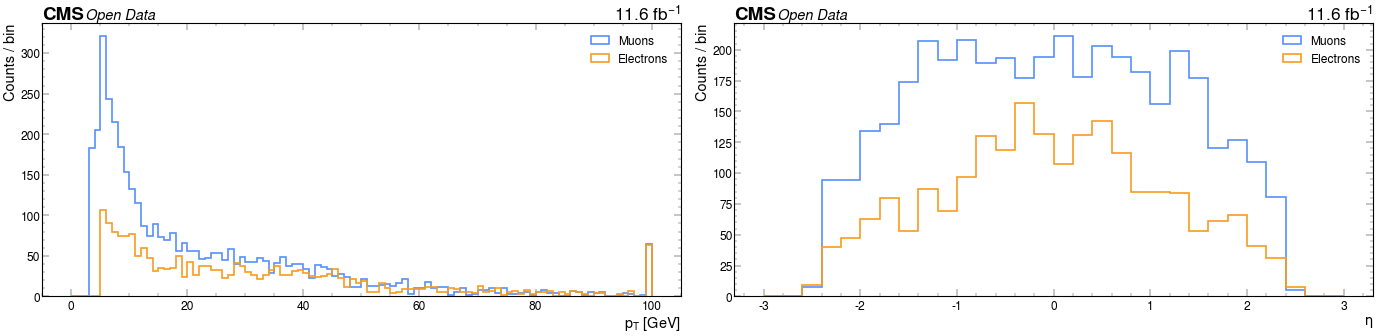

In [4]:
muons = data["muons"]
electrons = data["electrons"]

plot_kinematics(muons, electrons, label = ["Muons", "Electrons"])

Jetzt können wir die Bedingungen an die Objekte, die wir oben definiert haben, implementieren. Dazu nutzen wir die "Relationalen Operatoren"  `>`  und  `<`, die ihr im Pythontutorial kennengelernt habt:

In [5]:
passes_pt = (muons["pt"] > 5)
passes_eta = abs(muons["eta"]) < 2.4

Von jetzt an, wollen wir uns nur noch die Myonen angucken, die diese Anforderungen erfüllen. Da beide Anforderungen erfüllt sein sollen, nutzen wir den "und" operator `&`. Wir können zusätzlich auch die Anzahl aller Myonen in unserem Datensatz vor und nach dem Cut ausgeben lassen um zu sehen, wie viel Myonen wir verlieren.

In [6]:
print("Anzahl Myonen vor dem Cut:", ak.sum(ak.num(muons)))

muons = muons[passes_pt & passes_eta]

print("Anzahl Myonen nach dem Cut:", ak.sum(ak.num(muons)))

Anzahl Myonen vor dem Cut: 3946
Anzahl Myonen nach dem Cut: 3547


Wenn wir uns nun nochmal die Histogramme anschauen sehen wir, dass es keine Myonen mit einem $p_\text{T}$ unter $5 \ \text{GeV}$ und keine Myonen mit $|\eta| > 2.4$ mehr gibt:

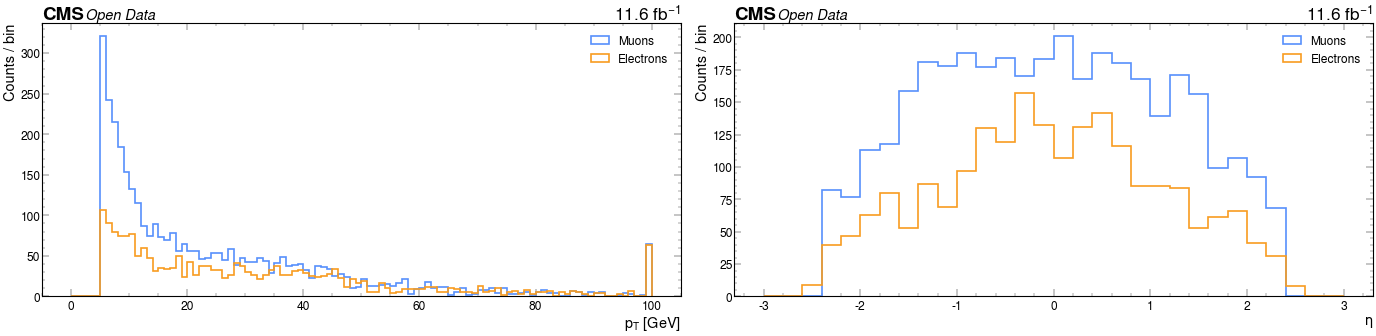

In [7]:
plot_kinematics(muons, electrons, label = ["Muons", "Electrons"])

Nun müssen aber nicht nur die Myonen, sondern auch die Elektronen $p_\text{T}$ und $\eta$ Anforderungen erfüllen (siehe oben). Versucht im Folgenden diese zu implementieren. Um zu überprüfen ob alles funktioniert hat, gebt euch die Anzahl der Elektronen vor und nach Cut aus. Schaut euch ebenfalls die Histogramme nochmals an!

Anzahl Elektronen vor dem Cut: 2093
Anzahl Elektronen nach dem Cut: 1880


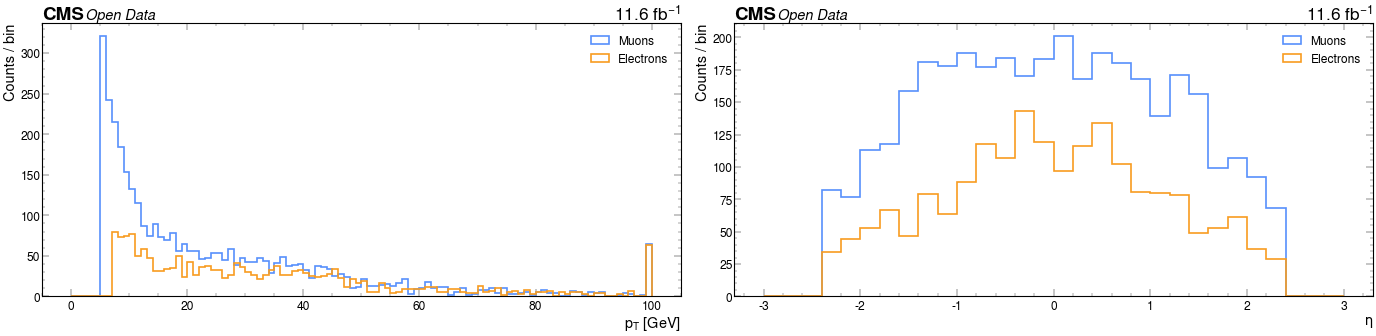

In [8]:
# TODO: Implementiert hier die Elektron Bedingungen equivalent zu dem, was wir oben für die Myonen gemacht haben!
# TODO: Wie viele Elektronen waren vor und nach dem Cut im Datensatz vorhanden?

electrons = data["electrons"]
n_electrons = ak.num(electrons)
print("Anzahl Elektronen vor dem Cut:", ak.sum(n_electrons))

passes_pt = electrons["pt"] > 7
passes_eta = abs(electrons["eta"]) < 2.4
electrons = electrons[passes_pt & passes_eta]
n_electrons = ak.num(electrons)
print("Anzahl Elektronen nach dem Cut:", ak.sum(n_electrons))

plot_kinematics(muons, electrons, label = ["Muons", "Electrons"])

Spielt gerne mit den Cuts herum! Erhöht die Anforderungen, gebt euch die kinematischen Eigenschaften aus und überprüft ob die Cuts funktioniert haben!

<a name="selektion"></a>
## [Selektion der Events](#überblick)

Nachdem wir nun unsere Myonen und Elektronen gefiltert haben, können wir uns die kombinierte Masse der vier Leptonen $m_{4\ell}$ anschauen. Das entsprechende Histogramm kann mit der Funktion `plot_m4l()` erstellt werden, wobei die Elektronen und Myonen als Argumente übergeben werden müssen:

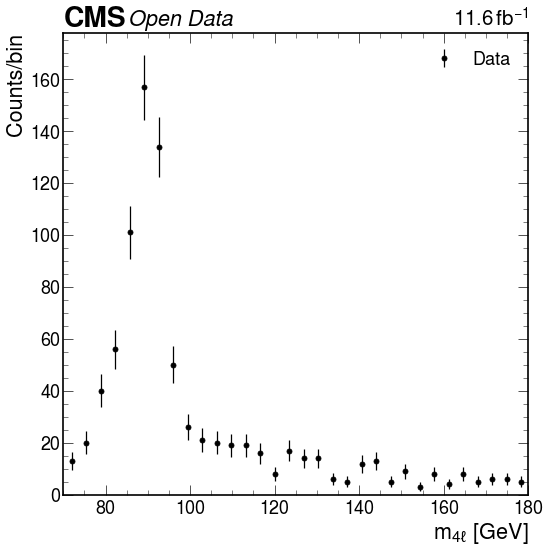

In [9]:
plot_m4l(electrons, muons)

Wir sehen einen markanten Peak, der ber einer Masse von ungefähr $90 \ \text{GeV}$ liegt. Das dazugehörige Teilchen kennen wir bereits - es ist das $Z$-Boson (eines der Austauschteilchen der schwachen Wechselwirkung). Doch vom Higgs-Boson, welches wir bei einer Masse von $125 \ \text{GeV}$ erwarten, fehlt jede Spur. Der Grund hierfür sind **Hintergrundevents**, in anderen Worten, Prozesse die - wie unser Signal -ebenfalls vier Leptonen erzeugen und somit in unserem Histogramm gelandet sind. Wenn wir zu viele dieser Hintergrundevents in unser Histogramm lassen, können wir den Peak des Higgs-Bosons nicht erkennen. In diesem Kapitel versuchen wir die Events zu filtern um Hintergrundevents und $\text{H}\to\text{ZZ}\to4\ell$ Events besser zu trennen. Schauen wir uns zunächst die folgenden Events an:

In [10]:
event_idx = 30
print("Event #31")
print("Myon Ladung:", muons["charge"][event_idx])
print("Elektron Ladung:", electrons["charge"][event_idx])

event_idx = 0
print("\nEvent #1")
print("Myon Ladung:", muons["charge"][event_idx])
print("Elektron Ladung:", electrons["charge"][event_idx]) 

Event #31
Myon Ladung: [1, 1, -1]
Elektron Ladung: [-1]

Event #1
Myon Ladung: [-1, 1]
Elektron Ladung: [1, 1]


Um zu verstehen, was an diesen Events "falsch" ist, werfen wir nochmals einen Blick auf das Feynman-Diagramm unseres $\text{H}\to\text{ZZ}\to4\ell$ Signalprozesses:

<img src="feynman.png" alt="Feynman_HtoZZto4l" width="300"> 

- In Event #31 finden wir **drei** Myonen und **ein** Elektron. Allerdings kann ein $Z$-Boson nur in Leptonen des gleichen Typs zerfallen, also entweder $Z\to e^{+}e^{-}$ oder $Z\to \mu^{+}\mu^{-}$. Es ist also unmöglich eine ungerade Anzahl and Myonen bzw. Elektronen vorzufinden.

- In Event #1 finden wir zwei Myonen und zwei Elektronen. Jedoch sind die Ladungen der Elektronen gleich. Da das $Z$-Boson elektrisch neutral ist müssen sich die Ladungen der Zerfallsleptonen aufheben. Das ist hier jedoch nicht der Fall.

Damit können die beiden obigen Events keine Signalevents sein. In den folgenden Unterkapiteln werden wir Filter einbauen, die **alle** Events entfernen, die ungerade Elektron- bzw. Myonzahlen aufweisen, sowie gegen die Ladungserhaltung verstoßen.

### Anzahl der Elektronen und Myonen
Als ersten Selektionsschritt können wir nun für alle Events fordern, dass es eine gerade Anzahl an Elektronen und Myonen geben muss. Unter dieser Voraussetzung, gibt es für uns drei verschiedene Fälle zu betrachten. Der erste Fall wäre, dass es 4 Elektronen gibt und keine Myonen. Welche weiteren zwei Fälle gibt es?

In **Python** kann man Forderungen an die Anzahl bestimmter Objekte mit der Funktion `ak.num()` machen (num ist hier kurz für "number", also Anzahl). Im Folgenden ist der Fall 4 Elektronen und 0 Myonen bespielhaft implementiert. Ergänzt diesen Fall um die beiden anderen Fälle, die ihr euch überlegt habt.

In [11]:
fall_1 = (ak.num(muons) == 0) & (ak.num(electrons) == 4)
# TODO: Implementiert hier Fall 2 und Fall 3
fall_2 = (ak.num(muons) == 4) & (ak.num(electrons) == 0)
fall_3 = (ak.num(muons) == 2) & (ak.num(electrons) == 2)

Nun verlangen wir von allen events, dass sie einen dieser Fälle erfüllen, dafür benutzen wir die "oder" funktion in python`|`:

In [12]:
passes_num = fall_1 | fall_2 | fall_3
electrons = electrons[passes_num]
muons = muons[passes_num]

Jetzt können wir uns erneut die Verteilung der $m_{4\ell}$ ansehen:

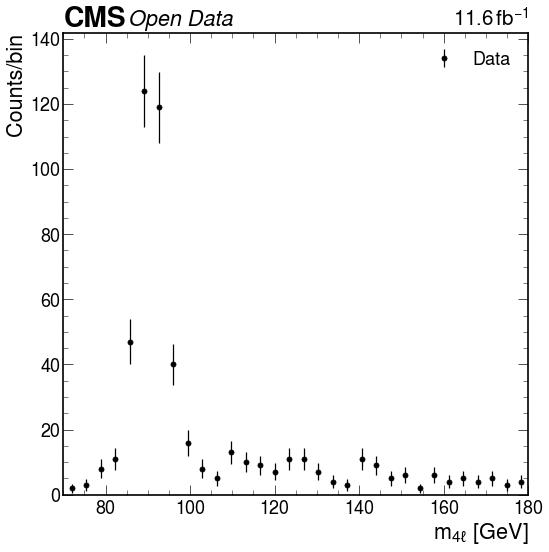

In [13]:
plot_m4l(electrons, muons)

### Ladung der Leptonen
Als zweiten Selektrionsschritt verlangen wir dass die Summe der Elektronladungen und die Summe der Myonladungen beide null sind. Für Elektronen kann dies wir folgt implementiert werden:

In [14]:
sum_charge_electron = ak.sum(electrons["charge"], axis = 1)
has_0Q_electrons = (sum_charge_electron == 0)

Hierbei berechnet die Funktion `ak.sum()` die summe der Ladung der Elektronen (`electrons["charge"]`), wobei `axis=1` bewirkt, dass das für jedes Event einzeln gemacht wird und nicht die Ladung über alle Events summiert wird. Dann fordern wir, dass diese Summe genau gleich null ist (`== 0`). Macht im folgenden Block das Gleiche für die Myonen!

In [15]:
# TODO: Implementiert die Ladungsanforderung für die Myonen!
sum_charge_muon = ak.sum(muons["charge"], axis = 1)
has_0Q_muons = (sum_charge_muon == 0)

Diese Forderungen wenden wir jetzt auf alle Events an, wobei immer **beides** gelten muss, Ladungssumme der Elektronen **und** (`&`) der Myonen ist null:

In [16]:
passes_0Q = has_0Q_electrons & has_0Q_muons
electrons = electrons[passes_0Q]
muons = muons[passes_0Q]

Nachdem wir diese zweite Bedingung eingebaut haben, können wir uns wieder die Verteilung $m_{4\ell}$ anzeigen lassen. Macht das in diesem nächsten Block:

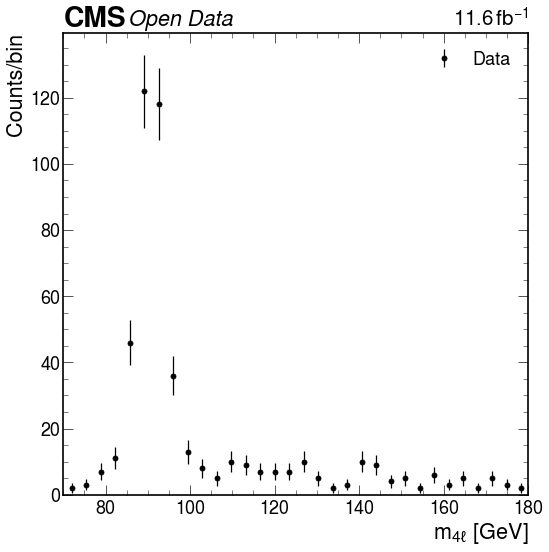

In [17]:
# TODO: Lasst euch die m_4l verteilung anzeigen!
plot_m4l(electrons, muons)

Jetzt könnt ihr womöglich schon einen kleinen Peak bei $125\,\text{GeV}$ sehen. Um diesen noch deutlicher sichtbar zu machen, wenden wir nun eine Bedingung an, die den Untergrund noch weiter reduzieren soll.

### Z Massen Fenster
Da die vier Leptonen in unserem Endzustand aus zwei Z-Bosonen entspringen, können wir uns jetzt die Leptonen angucken, die am ehesten "zusammen gehören", also vom gleichen Z abstammen. Für diese sollte nämlich gelten, dass die invariante Masse ungefähr der Z Masse ($m_Z = 91\,\text{GeV}$) enspricht. Außerdem ergibt es Sinn zu fordern, dass die Leptonen in einem solchen Paar, nicht zu nah aneinander sind, damit wir sicher sein können, dass beide tatsächlich aus dem ursprünglichen Prozess kommen und nicht eines erst später abgestrahlt wurde.

Etwas konkreter, rekonstruieren wir mit einem Algorithmus (implementiert als `get_Z_candidates()`) die zwei Leptonpaare die am ehesten zusammen gehören und berechnen deren kombinierte Masse und Abstand. Für die invariante Masse von Paar 1 soll gelten $40\,\text{GeV} < $ `m_Z1` $<120\,\text{GeV}$, für Paar 2 soll gelten $12\,\text{GeV} < $ `m_Z2` $ <120\,\text{GeV}$. Für die Abstände der Leptonen von Paar 1 und Paar 2 soll gelten `dR1`$>0.02$, bzw. `dR2` $>0.02$.

Im folgenden Block ist eine Implementierung angefangen. Versucht diese zu vervollständigen!

> **Good to know:** Die Funktion `get_Z_candidates()` geht alle möglichen (und erlaubten) Kombination von Leptonen durch und wählt das Leptonpaar, dessen Masse am nähesten am Z-Boson liegt als Paar #1 aus. Das übrig gebliebene Paar ist dann Paar #2. 

In [18]:
### Z Fenster
mZ_1, mZ_2, dR1, dR2 = get_Z_candidates(muons, electrons)
passes_Z1 = (mZ_1 > 40) & (mZ_1 < 120)
passes_Z2 = (mZ_2 > 12) & (mZ_2 < 120)

### dR cut
passes_dRcut = (dR1 > 0.02) & (dR2 > 0.02)

# Beide zusammenführen
passes_Zcuts = passes_Z1 & passes_Z2 & passes_dRcut
electrons = electrons[passes_Zcuts]
muons = muons[passes_Zcuts]

Und nun könnt ihr euch $m_{4\ell}$ wieder anzeigen lassen:

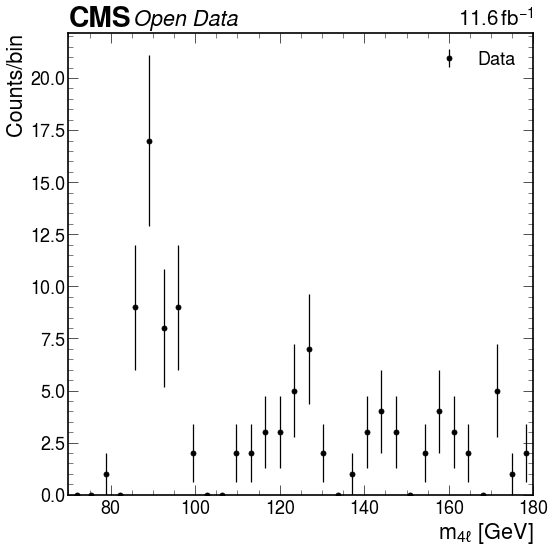

In [19]:
plot_m4l(electrons, muons)

Probiert mal die Fenstergröße um die Z-Masse, sowie den dR-cut zu verändern und guckt, wie es sich auf die $m_{4\ell}$-Verteilung auswirkt. 

### $p_\text{T}$ Bedingung im 2e2$\mu$ Kanal

Im 2e2 $\mu$ kanal muss aus "technischen" Gründen (bei Interesse fragt gerne die Betreuer*innen) ein zusätzlicher $p_\text{T}$ cut gemacht werden. Dieser ist implementiert als `get_2e2mu_pT_cut()`:

In [20]:
passes_pt_2e2mu = get_e_mu_pT_cut(electrons, muons)
electrons = electrons[passes_pt_2e2mu]
muons = muons[passes_pt_2e2mu]

Diese letzte Anforderung sollte aber keinen großen Unterschied machen:

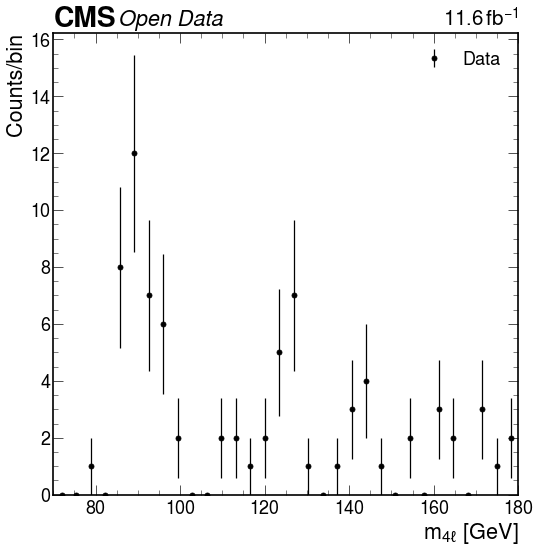

In [21]:
plot_m4l(electrons, muons)


<a name="Simulation"></a>
## [Vergleich mit Simulation](#überblick)

Nun, da wir alle relevanten Bedingungen an die Daten gestellt haben, können wir genau das Gleiche mit unserer SImulation machen. Dazu benutzen wir einen `for`-loop (siehe python-intro). Im ersten Schritt lesen wir alle Daten/Simulationen ein. Diese sind im Ordner `simulation_files` gespeichert. Die Name aller Dateien in diesem Ordnern können wir uns mit dem Befehl `os.listdir()` anzeigen lassen:

In [23]:
file_names = os.listdir("sim_files")
print(file_names)

['ZZTo4e.h5', 'ZZTo4mu.h5', 'SMHiggsToZZTo4L.h5', 'ZZTo2e2mu.h5']


Jetzt können wir über all diese Dateien "loopen" und die entsprechenden Daten speichern. Dafür nutzen wir den Befehl `load_simulation()`

In [24]:
datasets = {}
for file_name in file_names:
    print("Working on:", file_name)
    datasets.update(load_simulation(file_name))
print("Finished!")

Working on: ZZTo4e.h5


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'simulation_files/ZZTo4e.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
masses = {}

for name, dataset in datasets.items():
    print(f"Processing dataset {name}")

    electrons = dataset["electrons"]
    muons = dataset["muons"]
    n_Events_before = len(muons)

    m4l = perform_all_cuts(electrons, muons)
    n_Events_after = len(m4l)

    print(f"   Events before processing: {n_Events_before}")
    print(f"   Events after processing: {n_Events_after}")
    
    masses.update({name: m4l})

In [ ]:
bin_start = 60
bin_stop = 180
number_of_bins = 36

bins_m4l = np.linspace(bin_start, bin_stop, number_of_bins)

plot_m4l_bkg(masses, blinded = False, bins=bins_m4l)